In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/plant_dataset_split - Copy.zip" -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1071).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (109).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1094).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1108).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1109).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (112).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1121).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1135).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1137).JPG  
  inflating: /content/da

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train_path = '/content/dataset/plant_dataset_split - Copy/train'
val_path = '/content/dataset/plant_dataset_split - Copy/val'
test_path = '/content/dataset/plant_dataset_split - Copy/test'

In [5]:
# Image parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 64

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 49179 images belonging to 39 classes.
Found 9213 images belonging to 39 classes.
Found 3094 images belonging to 39 classes.


In [6]:
# Get number of classes and class names
NUM_CLASSES = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
print(f"Number of classes: {NUM_CLASSES}")
print(f"Class names: {class_names}")

Number of classes: 39
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot'

In [7]:
# Compute class weights for imbalance
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_path, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

total_samples = sum(class_counts.values())
class_weights = {train_generator.class_indices[class_name]: total_samples / (NUM_CLASSES * count)
                 for class_name, count in class_counts.items()}
print("Class weights:", class_weights)

Class weights: {0: 1.57625, 1: 1.57625, 2: 1.57625, 3: 0.9582066869300911, 4: 1.3796498905908097, 5: 1.0499583680266444, 6: 1.4994054696789536, 7: 1.57625, 8: 1.57625, 9: 1.323189926547744, 10: 1.57625, 11: 1.3573735199138859, 12: 1.3358050847457628, 13: 1.1401446654611211, 14: 1.466279069767442, 15: 1.57625, 16: 0.2862656072644722, 17: 0.6864452912357104, 18: 1.57625, 19: 1.57625, 20: 1.0668358714043993, 21: 1.57625, 22: 1.57625, 23: 1.57625, 24: 1.57625, 25: 0.3096758349705305, 26: 0.8589918256130791, 27: 1.4216459977452085, 28: 1.57625, 29: 0.7413286302175192, 30: 1.57625, 31: 0.8258022265880812, 32: 1.57625, 33: 0.8905367231638418, 34: 0.941044776119403, 35: 1.1228851291184327, 36: 0.29428238039673277, 37: 1.57625, 38: 0.9913522012578616}


In [10]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(128, 128, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(16, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(8, (3, 3)),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128),
    Activation('relu'),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 61, 61, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 39)             │         5,031 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,543 (830.25 KB)

 Trainable params: 212,543 (830.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-4,verbose=1)
    ],
    verbose=1
)

Epoch 1/50
768/768 ━━━━━━━━━━━━━━━━━━━━ 73s 89ms/step - accuracy: 0.2126 - loss: 2.9100 - val_accuracy: 0.6666 - val_loss: 1.1893 - learning_rate: 0.0010
Epoch 2/50
  1/768 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5469 - loss: 1.4537

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


768/768 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5469 - loss: 1.4537 - val_accuracy: 0.6725 - val_loss: 1.1722 - learning_rate: 0.0010
Epoch 3/50
768/768 ━━━━━━━━━━━━━━━━━━━━ 62s 80ms/step - accuracy: 0.5755 - loss: 1.4968 - val_accuracy: 0.7224 - val_loss: 0.9349 - learning_rate: 0.0010
Epoch 4/50
768/768 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.5156 - loss: 1.4649 - val_accuracy: 0.7291 - val_loss: 0.9091 - learning_rate: 0.0010
Epoch 5/50
768/768 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.6483 - loss: 1.1919 - val_accuracy: 0.7662 - val_loss: 0.7468 - learning_rate: 0.0010
Epoch 6/50
768/768 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6406 - loss: 1.2691 - val_accuracy: 0.7619 - val_loss: 0.7548 - learning_rate: 0.0010
Epoch 7/50
768/768 ━━━━━━━━━━━━━━━━━━━━ 62s 81ms/step - accuracy: 0.6827 - loss: 1.0666 - val_accuracy: 0.8065 - val_loss: 0.6223 - learning_rate: 0.0010
Epoch 8/50
768/768 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7500 - loss: 0.9633 

In [12]:
model.save('/content/drive/My Drive/crop_disease_cnn_batch643lyr001redLR.keras')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/crop_disease_cnn.keras')

ValueError: File not found: filepath=/content/drive/MyDrive/crop_disease_cnn.keras. Please ensure the file is an accessible `.keras` zip file.

In [13]:
# Evaluate on test set
test_generator.reset()
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE
)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8844 - loss: 0.3689
Test Loss: 0.3875, Test Accuracy: 0.8727
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step
Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.82      0.80      0.81        50
                            Apple___Black_rot       0.88      0.84      0.86        50
                     Apple___Cedar_apple_rust       0.71      0.88      0.79        50
                              Apple___healthy       0.83      0.90      0.87        83
                    Background_without_leaves       0.82      0.91      0.86        58
                          Blueberry___healthy       0.87      0.95      0.91        76
                      Cherry___Powdery_mildew       0.71      0.85      0.77        54
                             Cherry___healthy       0.88      0.92      0.90        50
   Corn___Cercospora_leaf_spot Gray_le

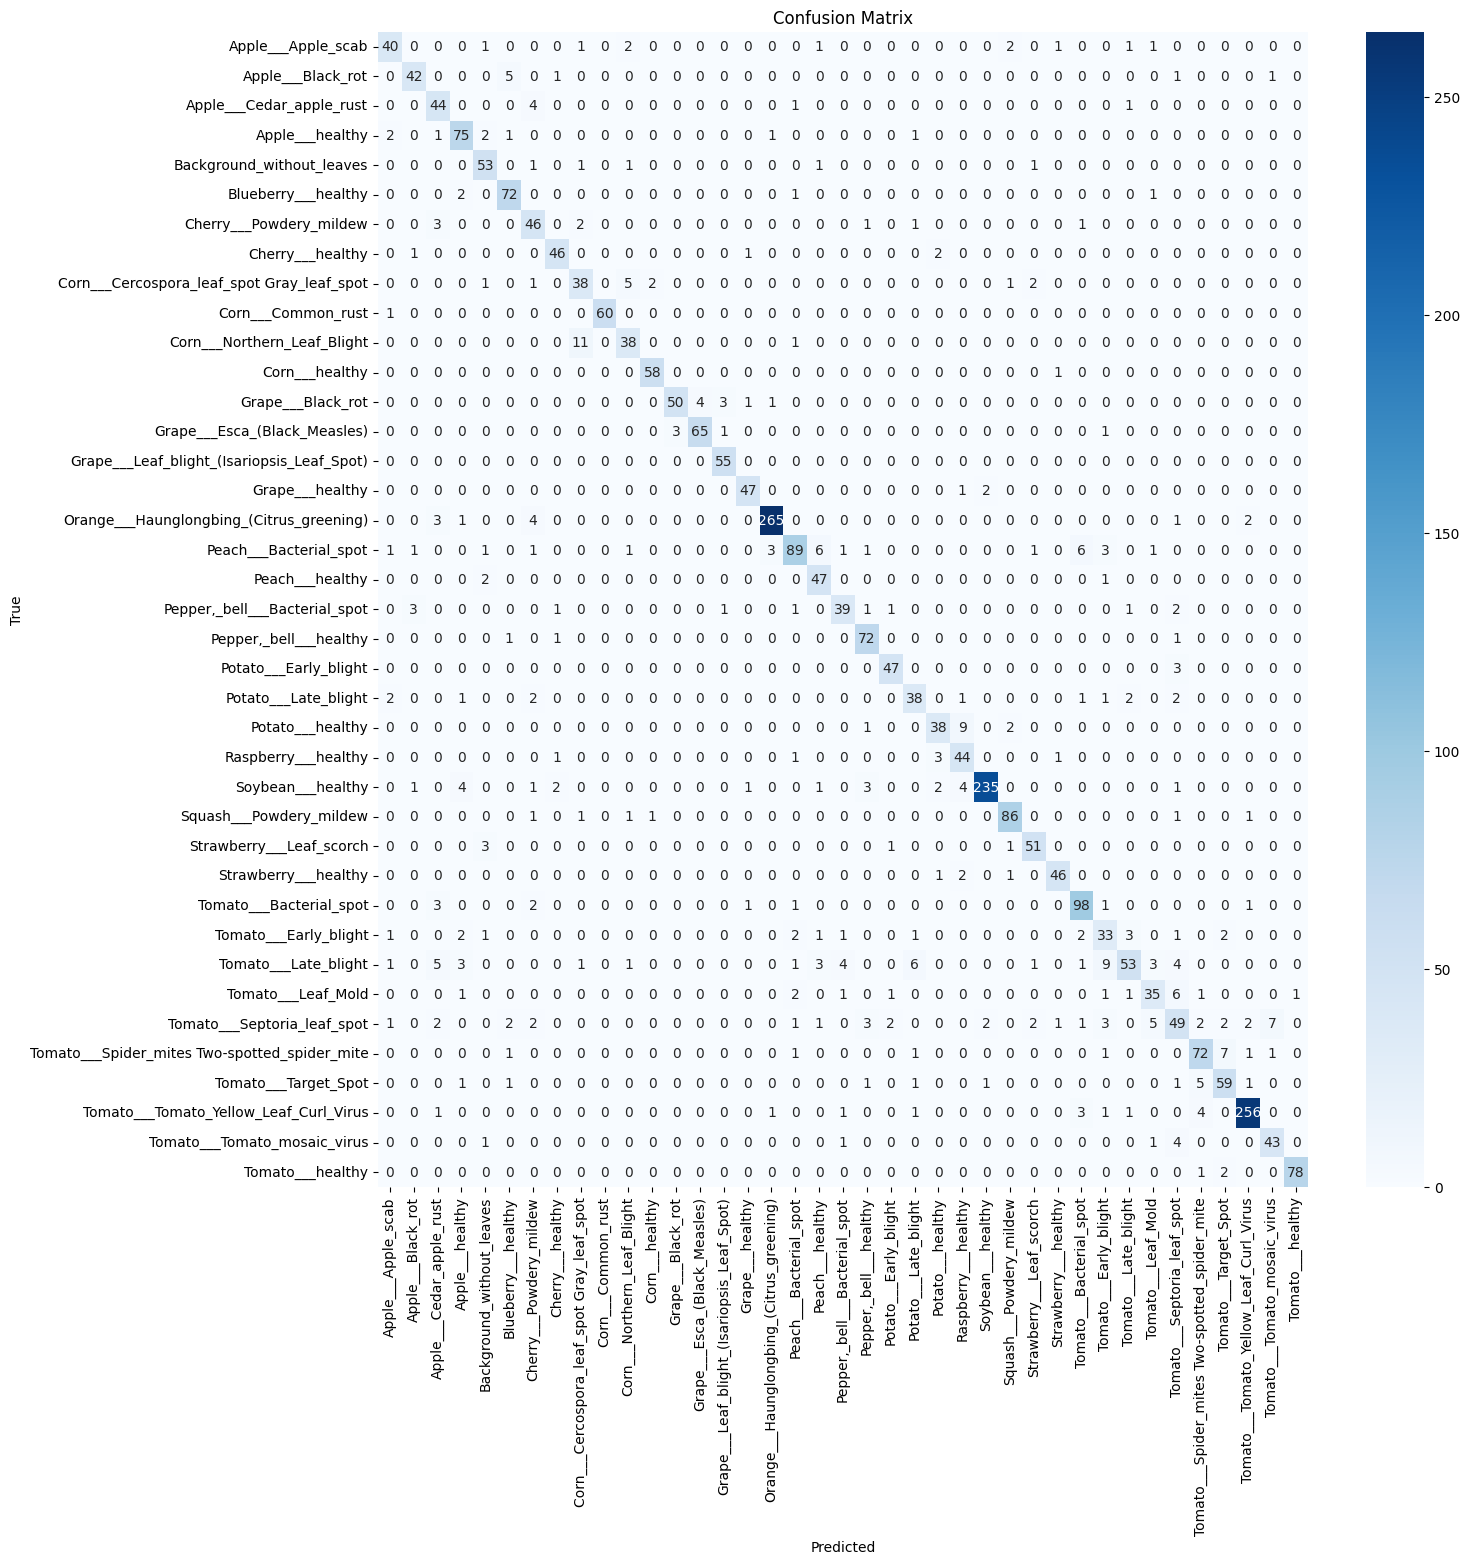

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



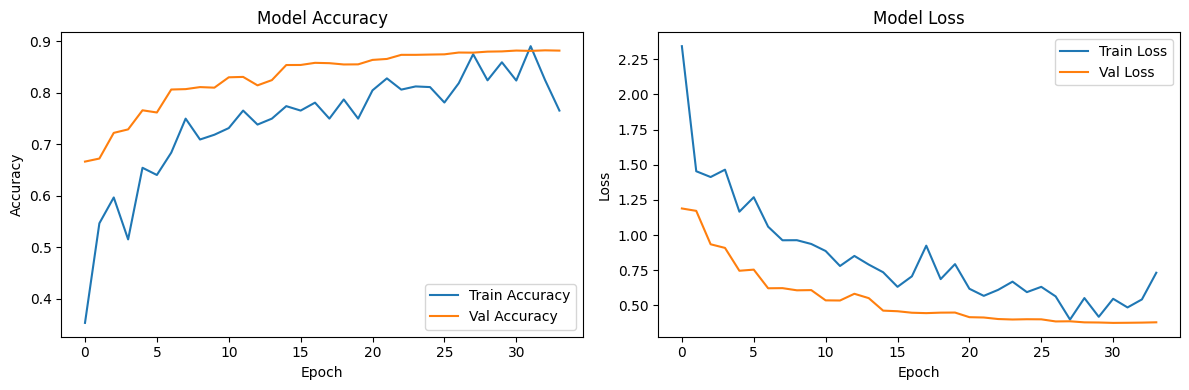

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

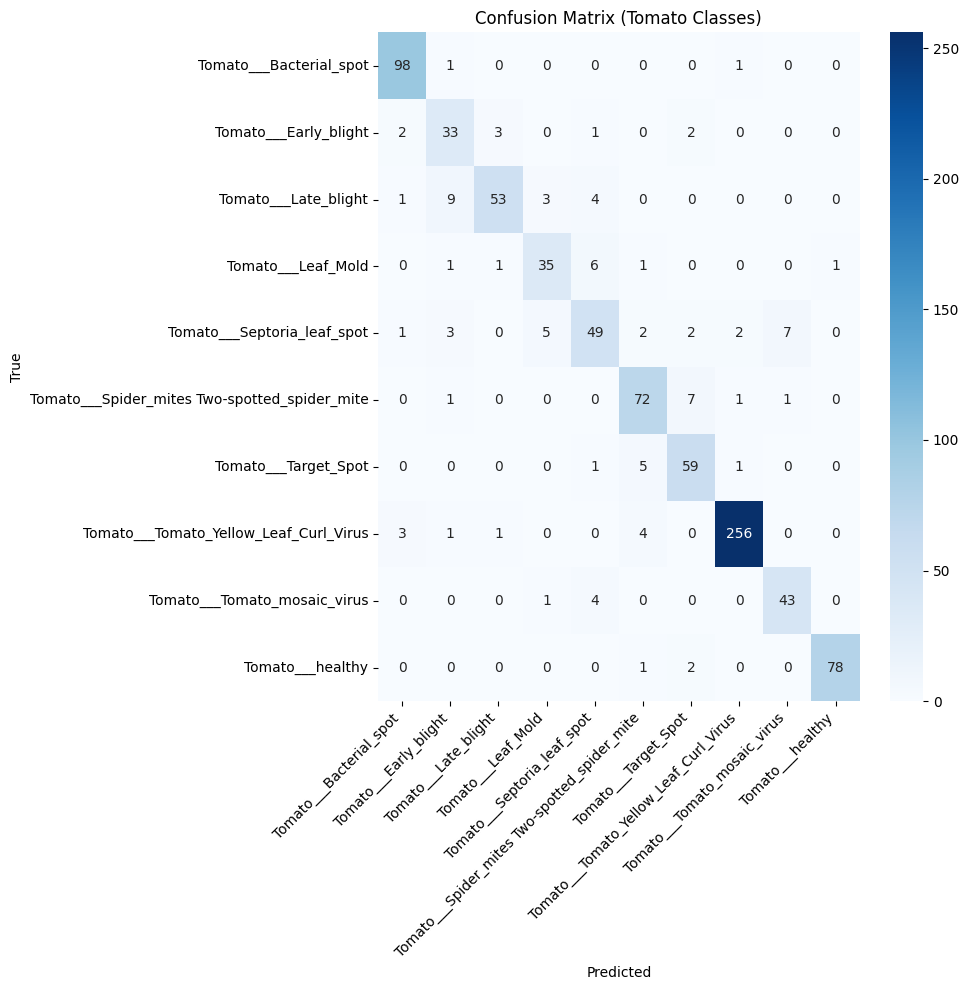

In [16]:
tomato_classes = [i for i, name in enumerate(class_names) if 'Tomato' in name]
cm_tomato = cm[tomato_classes][:, tomato_classes]
class_names_tomato = [class_names[i] for i in tomato_classes]
plt.figure(figsize=(10, 10))
sns.heatmap(cm_tomato, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_tomato, yticklabels=class_names_tomato)
plt.title('Confusion Matrix (Tomato Classes)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()